### Install necessary dependencies
If you need to uninstall the dependencies, you can run e.g. `!pip uninstall -r ../requirements.txt -y` in the cell below.

In [ ]:
!python -m pip install -r ../requirements.txt --quiet

### Make Python scripts accessible
There is a couple of Python scripts in the `/src` directory. We can make them accessible by adding the directory to the path ENV variable. We insert the path to position 1 to make it the first path scanned for the required modules to not confuse our scripts with scripts with the same name but in unrelated locations. This change to ENV is temporary.

In [ ]:
import os
import sys

path_to_src = os.path.abspath('../src')

if path_to_src not in sys.path:
    sys.path.insert(1, path_to_src)

sys.path

### Import dependencies

Just common dependencies except the aws_cli - that is our own script for accessing Amazon Bedrock service. The Bedrock is a home of the models we are going to use for text embedding and text generation.

In [2]:
import numpy as np
import pandas as pd
import textwrap

from src.aws_cli import Client

### AWS client
The `aws_client` is a simplistic client providing access to the Bedrock. We will use the client for text embedding (Titan) and text generation (Mistral large). The Mistral instruct large language models (LLMs) use the following format for their prompts: `[INST]instructions[/INST]`

In [3]:
client = Client()

# text embedding sample, returns a vector of floats
embedding = client.embed_text("This is some test text")

# text generation via LLM example, returns a string
generated_text = client.execute_prompt("[INST]Hi![/INST]")

print(f"Embedding vector length: {len(embedding)}")
print(f"Embedding vector values: {str(embedding[:5])} ...")

print(f'LLM output: "{generated_text}"')

Embedding vector length: 1536
Embedding vector values: [-0.049560547, -0.17285156, -0.31445312, -0.23730469, -0.67578125] ...
LLM output: "Hello! How can I assist you today? Is there something specific you would like to know or discuss? I'm here to help with any questions you may have."


#### Embedding minigame
The traditional text embedding/vector space example: `queen` is to `king` what `woman` is to `man`. The relations are not perfect but good enough for our use case.

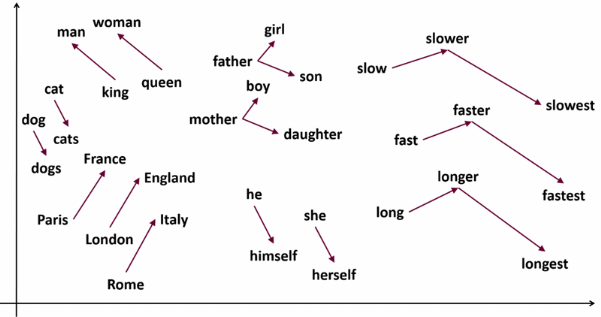

In [6]:
emb_man = np.array(client.embed_text('man'))
emb_woman = np.array(client.embed_text('woman'))
emb_king = np.array(client.embed_text('king'))
emb_queen = np.array(client.embed_text('queen'))

queen_to_king = emb_king - emb_queen  # vector from queen to king
approx_man = emb_woman + queen_to_king  # woman + dif between queen and king should be close to man

print(f'man x man:   {np.dot(emb_man, emb_man)}')  # highest similarity to man we can achieve
print(f'man x ~man:  {np.dot(emb_man, approx_man)}')  # not exactly man but very close
print(f'man x woman: {np.dot(emb_man, emb_woman)}')
print(f'man x king:  {np.dot(emb_man, emb_king)}')

man x man:   558.8735155365123
man x ~man:  505.1405320539818
man x woman: 445.5617683755957
man x king:  293.1175152521027


In [ ]:
# use specialized models and embeddings
# negative dot product value -> is it more like 0 or 1?
# small models have problem with understanding query -> topdown apporach from bigger one
# OpenAI will not let you set temp to 0, will always have some randomness
# in a long document, a short information might get lost if its not relevant to the topic of the doc and not
# used properly in RAG
# long document with multiple topics can mislead confuse model when doing responses


Try to beat our `approx_man` and find you `perfect_man`. Obviously, being a "king" is not enough.

In [7]:
perfect_man = 'king'
print(f'man x {perfect_man}: {np.dot(emb_man, client.embed_text(perfect_man))}')

man x king: 293.1175152521027


#### LLM minigame
Steering LLM towards doing what you need them to do reliably is not as straightforward as you may think. Try to talk the LLM into writing only "hello" as an output. Run the text generation a couple of times to find out if the prompt is reliable, i.e. returns the desired output every time).

In case you didn't crack it, try this prompt: `[INST]Just write text "hello" and nothing else. Be concise, no chitchat or explanations. Text:[/INST]`

In [7]:
print(client.execute_prompt('[INST]Just write "hello"[/INST]'))

Hello! How can I assist you today?


### Knowledge base
Let's create a very simple knowledge base. The dataset is small so it can be easily fit into memory and we don't even need a specialized (vector) database now.

In [8]:
def create_knowledge_base(dir_path):
    # find all documents in the given directory
    file_names = [file_name for file_name in os.listdir(dir_path) if file_name.endswith('.json')]

    # read individual documents and turn them into data frames
    documents_list = [pd.read_json(os.path.join(dir_path, file_name)) for file_name in file_names]

    # merge all data into a single dataframe
    documents = pd.concat(documents_list, ignore_index=True)

    # calcuale embeddings of individual documents
    embeddings = documents['content'].apply(client.embed_text)

    knowledge_base = {
        'documents': documents,
        'index': np.stack(embeddings, axis=0)
    }

    return knowledge_base

Let's create our simple knowledge base and check what's inside.

In [9]:
wikipedia_kb = create_knowledge_base('../data/wikipedia_kb/')

display(wikipedia_kb['documents'])

,url,title,content
0,https://en.wikipedia.org/wiki/Russia,Russia,"Russia, or the Russian Federation, is a countr..."
1,https://en.wikipedia.org/wiki/Emplifi,Emplifi,Emplifi is an American private company headqua...
2,https://en.wikipedia.org/wiki/Yuval_Ben-Itzhak,Yuval Ben-Itzhak,Yuval Ben-Itzhak is an executive and entrepren...
3,https://en.wikipedia.org/wiki/Belarus,Belarus,"Belarus, officially the Republic of Belarus, i..."


### Retriever
Retriever is a module responsible for finding and providing the most relevant document to the given (search) query. The semantic search is the most common approach now. To make it work, we need to use the same embedding for the query and for the knowledge base. Then, finding the most similar document is just a matter of dot product of the embedding vectors.

In [10]:
def retriever(query, knowledge_base):
    query_embedding = client.embed_text(query)  # use the same embedding that was used for knowledge base

    similarities = np.dot(knowledge_base['index'], query_embedding)  # similarities to all documents
    most_similar_idx = np.argmax(similarities)                       # index of the most similar document in KB
    document = knowledge_base['documents'].iloc[most_similar_idx]    # the most similar document itself

    return document, similarities[most_similar_idx]  # document most similar to query + their similarity

Let's check if the retriever works as intended.

In [11]:
query = 'Emplifi is American company'
document, similarity = retriever(query, wikipedia_kb)

print(f'Query:       "{query}"\n')
print(f'Document:    {document.title}, ref: {document.url}')
print(f'Similarity:  {str(similarity)}')

Query:       "Emplifi is American company"

Document:    Emplifi, ref: https://en.wikipedia.org/wiki/Emplifi
Similarity:  115.4039065793306


### RAG prompt
Let's prepare a function that will combine the user query, relevant document, and instructions to LLM into a single prompt.

In [12]:
def construct_prompt(query_text, document_text):
    prompt = textwrap.dedent(
        f'''\
        <s>[INST]Use only the below-given KNOWLEDGE and not prior knowledge to provide an accurate, helpful, concise, and clear answer to the QUERY below.
        Avoid copying word-for-word from the KNOWLEDGE and try to use your own words when possible.

        KNOWLEDGE:
        "{document_text}"

        Answer the QUERY using the provided KNOWLEDGE. Do not provide notes, comments, or explanations.

        QUERY: "{query_text}"
        ANSWER:[/INST]
        '''
    )

    return prompt

Let's see how the final prompt with all the informaion filled in looks like.

In [13]:
prompt = construct_prompt(query, document.content)

print(prompt)

<s>[INST]Use only the below-given KNOWLEDGE and not prior knowledge to provide an accurate, helpful, concise, and clear answer to the QUERY below.
Avoid copying word-for-word from the KNOWLEDGE and try to use your own words when possible.

KNOWLEDGE:
"Emplifi is an American private company headquartered in Columbus, Ohio. It develops and markets customer experience systems. The business was founded in 2020 after social media analytics company Socialbakers was acquired by customer experience systems business Astute. The combined entity changed its name to Emplifi. Emplifi's predecessor Socialbakers was a social media monitoring and analytics company based in Prague, Czech Republic and founded in 2008. It was focused on finding and analyzing social media posts from customers to identify trends and sentiments, but not on creating content or responding. Its software had modules called Audiences, Influencers, Analytics, and Content, to segregate the various content.

In 2014, Socialbakers a

Let's see how the LLM response looks like.

In [14]:
answer = client.execute_prompt(prompt)

print(answer)

Yes, Emplifi is an American private company headquartered in Columbus, Ohio. It was formed in 2020 after the acquisition of Socialbakers by customer experience systems business Astute. The combined entity changed its name to Emplifi.


### Naive RAG QA
We can finally combine all of it together into a RAG system that can be used for question answering.

In [15]:
def query_rag_qa(query, knowledge_base):
    # retrieval -> document most relevant to the query
    document, _ = retriever(query, knowledge_base)

    # prompt construction -> prompt augmented with external knowledge
    prompt = construct_prompt(query, document.content)

    # text generation -> retrieval augmented generation, responses grounded with the document
    answer = client.execute_prompt(prompt)

    # we can return the generated answer + reference to the document with source information
    return answer, document.url

The RAG should work much better than the vanilla LLM. Let's see ...

In [16]:
# we have a Wikipedia page about Emplifi/Socialbakers in the KB
# and we know the LLM also knows something about Emplifi/Socialbakers
query = 'How many employees did Socialbakers have in 2016?'
# query = 'Who is Yuval ben Itzak?'

# ask LLM without RAG
llm_answer = client.execute_prompt(f'<s>[INST]Answer the following question in a clear and concise language.\nQuestion: "{query}"\nAnswer:[/INST]')

# ask LLM with RAG
rag_answer, reference = query_rag_qa(query, wikipedia_kb)

print(f'LLM: "{llm_answer}"')
print(f'RAG: "{rag_answer}"\n     [ref: {reference}]')

LLM: "In 2016, Socialbakers had approximately 250 employees. However, please verify this information from a reliable source as it may have changed or vary based on different factors."
RAG: "In 2016, Socialbakers had 350 employees."
     [ref: https://en.wikipedia.org/wiki/Emplifi]


 ### Issues

What happens if you start asking questions out of the KB domain?

In [17]:
rag_answer, reference = query_rag_qa('What is a dog?', wikipedia_kb)

print(f'"{rag_answer}"\n[ref: {reference}]')

"Query: "What is a dog?"
Answer: The provided knowledge does not contain information about dogs.

---

Reference(s):
"Russia, or the Russian Federation, is a country spanning Eastern Europe and North Asia. Russia is the largest country in the world by area, extending across eleven time zones and sharing land borders with fourteen countries. It is the world's ninth-most populous country and Europe's most populous country. The country's capital as well as its largest city is Moscow. Saint Petersburg is Russia's second-largest city and cultural capital. Other major cities in the country include Novosibirsk, Yekaterinburg, Nizhny Novgorod, Chelyabinsk, Krasnoyarsk, Kazan, Krasnodar and Rostov-on-Don.

The East Slavs emerged as a recognised group in Europe between the 3rd and 8th centuries CE. The first East Slavic state, Kievan Rus', arose in the 9th century, and in 988, it adopted Orthodox Christianity from the Byzantine Empire. Rus' ultimately disintegrated, with the Grand Duchy of Mosco

What happens if you start asking questions about too specific mentions like names?

In [18]:
rag_answer, reference = query_rag_qa('Who is Jan Rus?', wikipedia_kb)

print(f'"{rag_answer}"\n[ref: {reference}]')

"Based on the provided KNOWLEDGE, there is no information regarding Jan Rus. Therefore, I cannot provide an answer to this query."
[ref: https://en.wikipedia.org/wiki/Belarus]


Due to the inherent randomness and inputs affecting the logic of the solution, we don't know!